In [148]:
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install seaborn
# !pip install kaggle

## IMPORTAR LIBRERIAS ESTANDAR

In [149]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

## DECLARAR FUNCIONES

In [150]:
def get_unpivoted(df, id_vars, var_name, value_name):
    '''
    parameters:
       id_vars: type list, variables ids sobre el cual se toma referencia para el unpivot
       var_name: type str, la nueva variable que se genera a partir de las columnas donde se aplica el unpivot
       value_name: typestr, el valor correspondiente a las variables ids y la nueva variable generada (target)
    return: type dataframe, el nuevo df transformado con el unpivot
    '''
    df = df.melt(id_vars=id_vars, var_name=var_name, value_name=value_name)
    return df

In [151]:
import datetime as dt
def get_dict_semana(since, semana_inicio, semana_fin):
    '''
    parameters:
        since: type str, con el sgte formato 'YYYY-MM-DD'
        semana_inicio: type int, semana inicio de la data
        semana_fin: type int, semana fin de la data
    return: type dict, donde key es la semana_xx y los values son los periodo de inicio y fin de la semana
        
    '''
    periodo_ini = dt.datetime.strptime(since,'%Y-%m-%d')
    list_periodo = []
    for i in range(semana_inicio-1, semana_fin):
        aux = ''
        if i<9:
            aux = '0'+str(i+1)
        else:
            aux = str(i+1)

        periodo_fin = periodo_ini + dt.timedelta(days=6)
        list_periodo.append(['SEMANA_'+aux, periodo_ini, periodo_fin ])
        periodo_ini = periodo_fin + dt.timedelta(days=1)

    dict_semana = {item[0]:{'periodo_ini': item[1], 'periodo_fin':item[2]} for item in list_periodo}
    return dict_semana

In [152]:
def managing_semana(df, dict_semana):
    '''
    Aplicar feature engineering a las variable SEMANA_XX
    '''
    if 'FECHA_INICIO' not in df.columns:
        df['FECHA_INICIO'] = df['SEMANA_XX'].apply(lambda x: dict_semana.get(x)['periodo_ini'])
        df['FECHA_FIN'] = df['SEMANA_XX'].apply(lambda x: dict_semana.get(x)['periodo_fin'])
    return df

In [153]:
def get_dict_categ(df, column):
    '''
    parameters:
      column: type str, se refiere a la variable categorica 
    return: type dict, retorna un key_value de los valores de las variable categorica
    '''
    dict_categ = {}
    for n,i in enumerate(df[column].unique()):
        dict_categ[i] = str(n+1) ### modificar colum
    return dict_categ

In [154]:
def map_valores_categ(df):
    df['Z_MARCA'] = df['Z_MARCA'].map(dict_marca)
    df['Z_MODELO'] = df['Z_MODELO'].map(dict_modelo)
    df['Z_DEPARTAMENTO'] = df['Z_DEPARTAMENTO'].map(dict_departamento)
    df['Z_PUNTO_VENTA'] = df['Z_PUNTO_VENTA'].map(dict_ptoventa)
    df['Z_GAMA'] = df['Z_GAMA'].map(dict_gama)
    return df

In [155]:
def get_feature_selection(fi):
    ##method: encontar las variables con una importancia acumulativa al 99% y las variables con zero importancia
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.99:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 99% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance

In [156]:
def show_values_on_bars(axs, h_v="v", space=0.4, precision=1):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                val = p.get_height()
                if not str(p.get_height())=='nan':
                    value = val
                    if isinstance(value, float):
                        value = round(value, precision)
                    ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## LOAD DATA Y TRANSFORMACION

In [157]:
# /kaggle/input/datathon-entel-2022-reto2
ruta = '../data/'
train_raw = pd.read_csv(ruta+'train.csv')
test_raw =  pd.read_csv(ruta+'test.csv')

In [158]:
### unpivot
id_vars = ['Z_MARCA','Z_MODELO','Z_GAMA','Z_DEPARTAMENTO','Z_PUNTO_VENTA']
var_name = 'SEMANA_XX'
value_name = 'TARGET'

train_transform = get_unpivoted(train_raw, id_vars, var_name, value_name)
test_transform = get_unpivoted(test_raw, id_vars, var_name, value_name)
test_transform['TARGET'] = -1

In [159]:
### featuring engineering semana
dict_semana_train = get_dict_semana(since = '2021-05-17', semana_inicio = 1, semana_fin = 50)
dict_semana_test = get_dict_semana(since = '2022-05-02', semana_inicio = 51, semana_fin = 60)
train_transform = managing_semana(train_transform, dict_semana_train)
test_transform = managing_semana(test_transform, dict_semana_test)
train_transform.shape, test_transform.shape

((2358650, 9), (471730, 9))

In [160]:
## concat
demanda = pd.concat([train_transform, test_transform], axis=0)
demanda['TARGET'] = demanda['TARGET'].astype('int32')
demanda['ID'] = (demanda['Z_MODELO']+'|'+demanda['Z_PUNTO_VENTA']+'|'+ demanda['Z_GAMA']+'|'+demanda['SEMANA_XX'])
demanda.set_index('ID', inplace=True)
demanda.sort_values(['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA','SEMANA_XX'], inplace=True)
demanda

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,TARGET,FECHA_INICIO,FECHA_FIN
ID,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_01,0,2021-05-17,2021-05-23
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_02,0,2021-05-24,2021-05-30
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_03,0,2021-05-31,2021-06-06
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_04,0,2021-06-07,2021-06-13
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,0855cd73c3a9dc2c31a7c4dcaecfd53282238c6a457a5c...,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,110820d992b7649baca108cda049eff2fcf6804fd4c989...,0fedacb725c2c2128d2b42505880d91d238e616b926278...,SEMANA_05,0,2021-06-14,2021-06-20
...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_56,f4920dac3075feca0bd92a92f6691f50e9f815e5e398f8...,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,ee5949f8b5ff823b330c243762295ce7ede1a751f35b94...,ac45b56f385a5564f090e7afd47d721d3a491796bd3a12...,SEMANA_56,-1,2022-06-06,2022-06-12
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_57,f4920dac3075feca0bd92a92f6691f50e9f815e5e398f8...,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,ee5949f8b5ff823b330c243762295ce7ede1a751f35b94...,ac45b56f385a5564f090e7afd47d721d3a491796bd3a12...,SEMANA_57,-1,2022-06-13,2022-06-19
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_58,f4920dac3075feca0bd92a92f6691f50e9f815e5e398f8...,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,f793de205ead5ac302c4a1627829dea41f176b1068b993...,ee5949f8b5ff823b330c243762295ce7ede1a751f35b94...,ac45b56f385a5564f090e7af

In [161]:
### label_encoding variables categoricas
dict_marca = get_dict_categ(demanda, 'Z_MARCA')
dict_modelo = get_dict_categ(demanda, 'Z_MODELO')
dict_departamento = get_dict_categ(demanda, 'Z_DEPARTAMENTO')
dict_ptoventa = get_dict_categ(demanda, 'Z_PUNTO_VENTA')
dict_gama = get_dict_categ(demanda, 'Z_GAMA')
demanda = map_valores_categ(demanda)
demanda[['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA','SEMANA_XX','FECHA_INICIO','FECHA_FIN','TARGET']]

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,FECHA_INICIO,FECHA_FIN,TARGET
ID,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,2021-05-17,2021-05-23,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,2021-05-24,2021-05-30,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,2021-05-31,2021-06-06,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,2021-06-07,2021-06-13,0
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,2021-06-14,2021-06-20,0
...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_56,17,318,1,24,414,SEMANA_56,2022-06-06,2022-06-12,-1
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_57,17,318,1,24,414,SEMANA_57,2022-06-13,2022-06-19,-1
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_58,17,318,1,24,414,SEMANA_58,2022-06-20,2022-06-26,-1


## EDA

In [15]:
demanda_train = demanda[demanda['TARGET']>=0].copy()
demanda_test = demanda[demanda['TARGET']<0].copy()

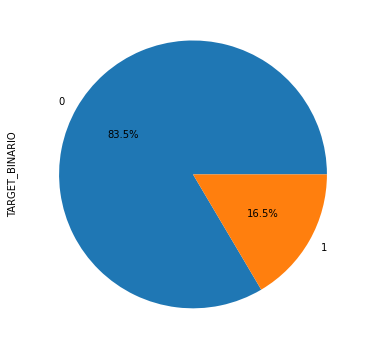

In [16]:
demanda_train['TARGET_BINARIO'] = demanda_train['TARGET'].apply(lambda x:  0 if x<1 else 1)
demanda_train['TARGET_BINARIO'].value_counts().plot.pie(autopct='%.1f%%', figsize=(6,8));

In [17]:
demanda_train[['Z_MARCA', 'Z_MODELO', 'Z_GAMA', 'Z_DEPARTAMENTO','Z_PUNTO_VENTA',
               'SEMANA_XX','FECHA_INICIO','FECHA_FIN','TARGET']].tail(50)

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,FECHA_INICIO,FECHA_FIN,TARGET
ID,,,,,,,,,
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,17,318,1,24,414,SEMANA_01,2021-05-17,2021-05-23,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,17,318,1,24,414,SEMANA_02,2021-05-24,2021-05-30,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,17,318,1,24,414,SEMANA_03,2021-05-31,2021-06-06,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,17,318,1,24,414,SEMANA_04,2021-06-07,2021-06-13,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,17,318,1,24,414,SEMANA_05,2021-06-14,2021-06-20,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_06,17,318,1,24,414,SEMANA_06,2021-06-21,2021-06-27,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_07,17,318,1,24,414,SEMANA_07,2021-06-28,2021-07-04,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_08,17,318,1,24,414,SEMANA_08,2021-07-05,2021-07-11,0
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_09,17,318,1,24,414,SEMANA_09,2021-07-12,2021-07-18,0


### Departamento

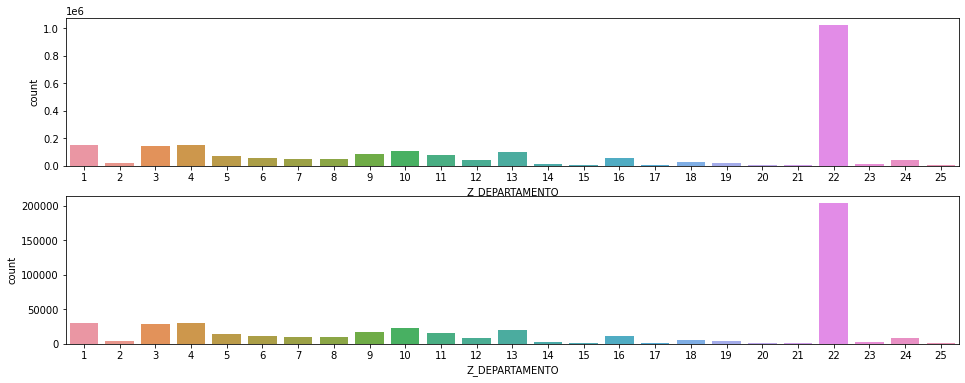

In [18]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))
sns.countplot(data=demanda_train, x='Z_DEPARTAMENTO', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_DEPARTAMENTO', ax=axes[1]);

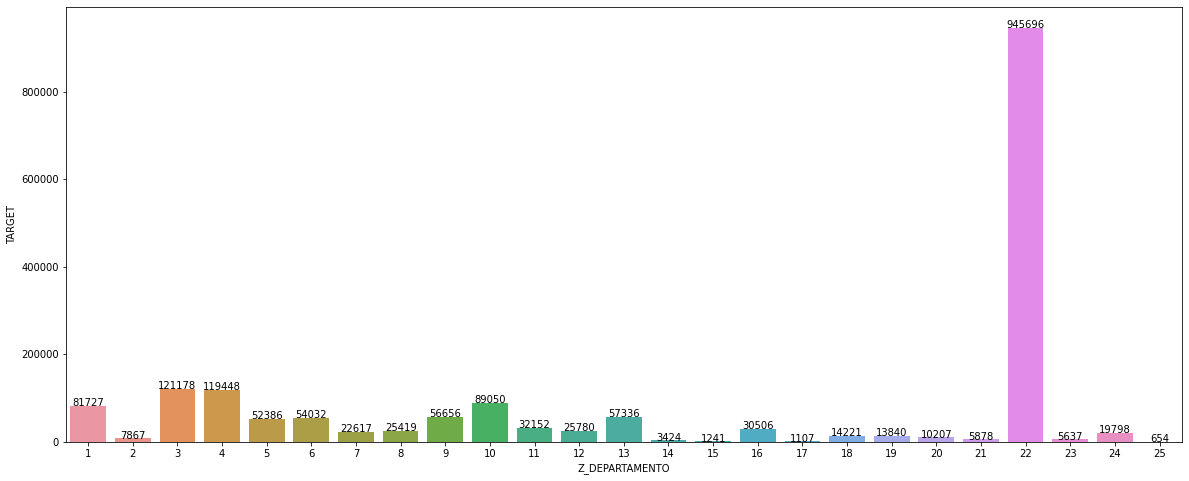

In [19]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

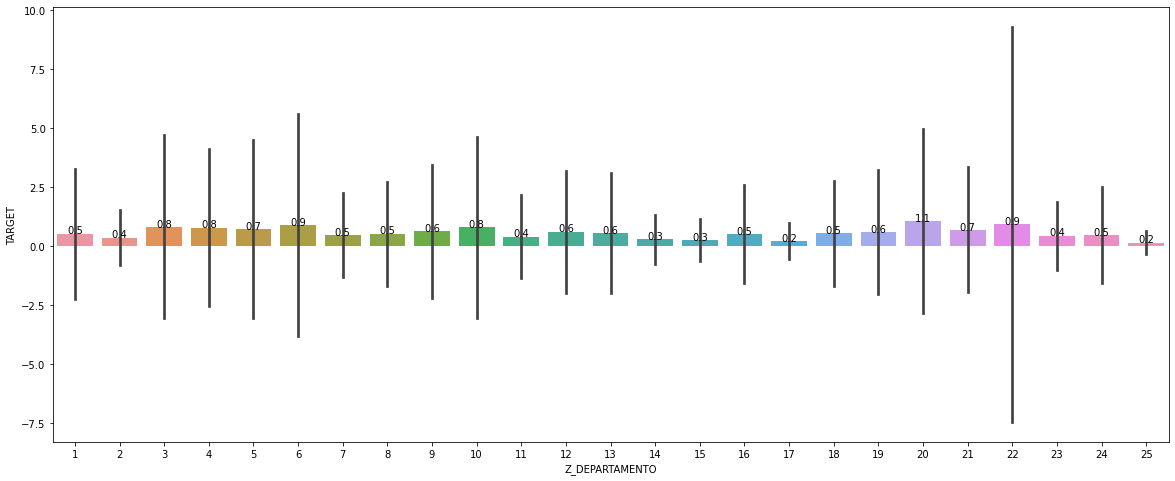

In [20]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

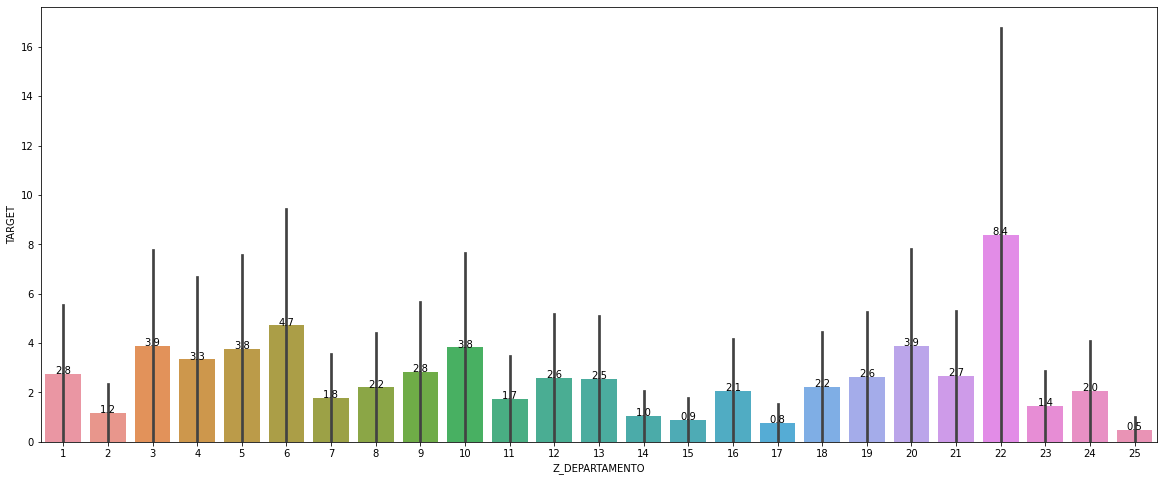

In [21]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

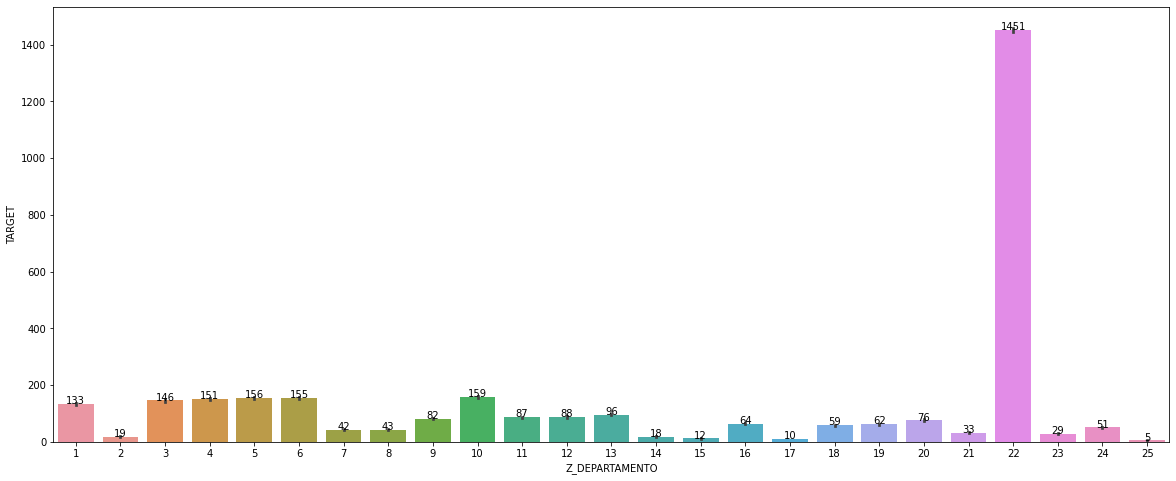

In [22]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_DEPARTAMENTO', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Marca

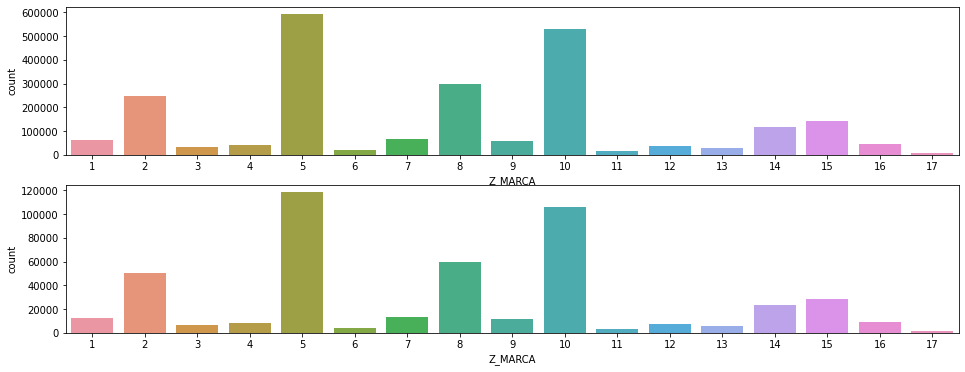

In [23]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))
sns.countplot(data=demanda_train, x='Z_MARCA', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_MARCA', ax=axes[1]);

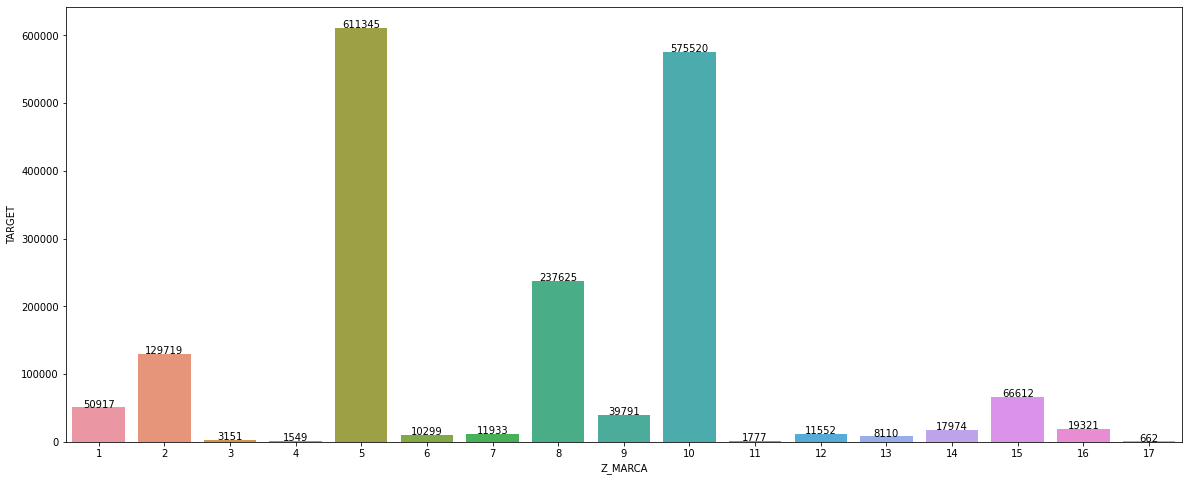

In [24]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

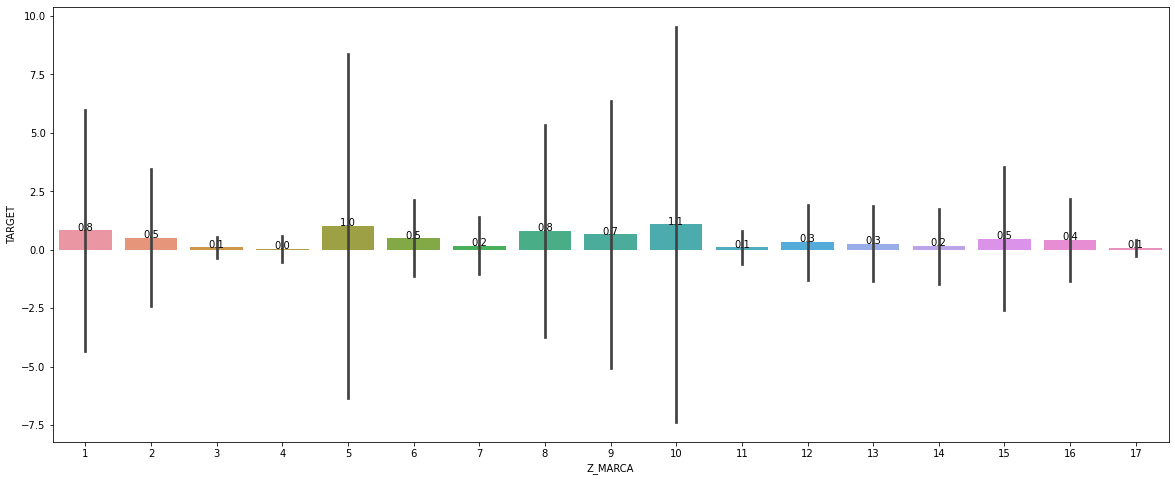

In [25]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

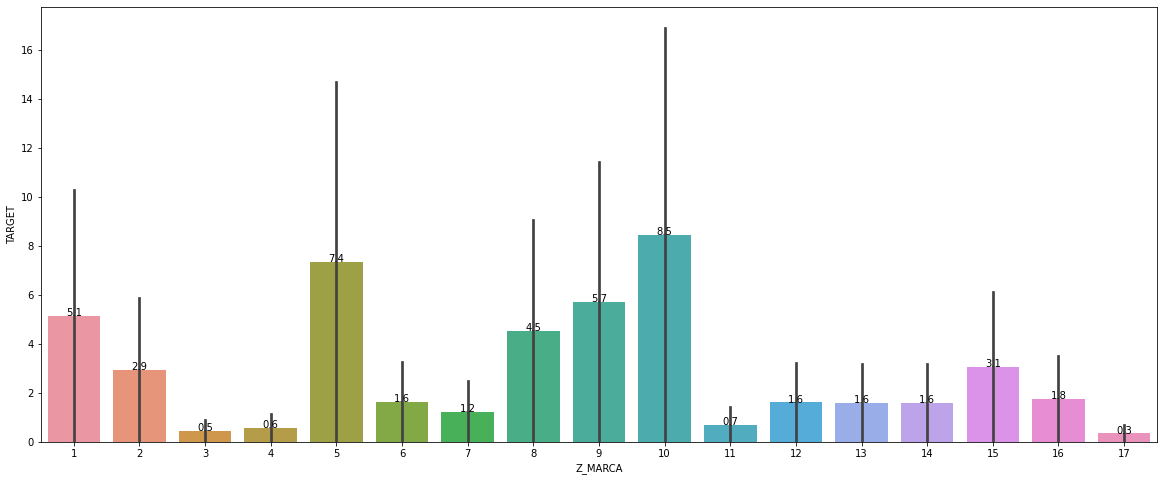

In [26]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

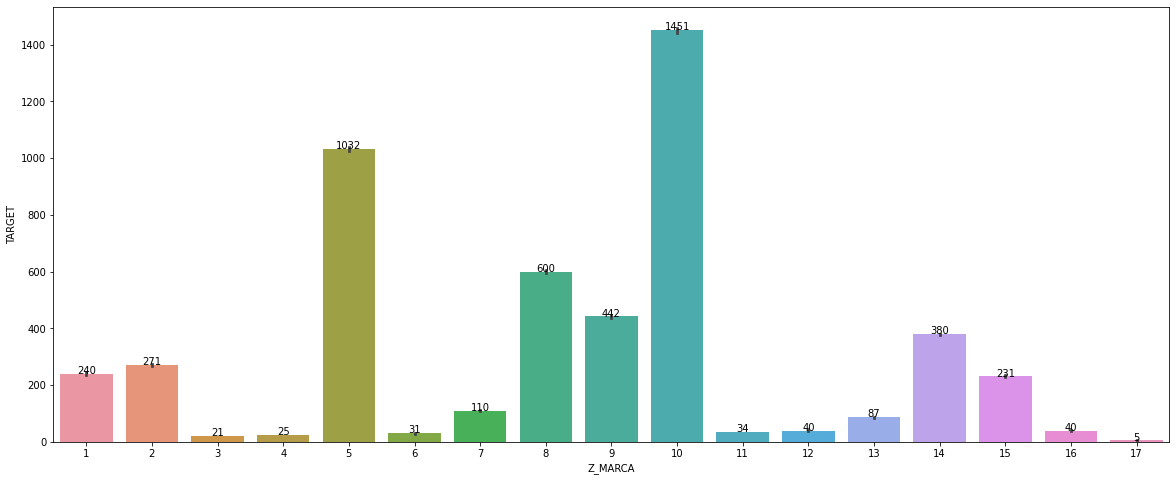

In [27]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_MARCA', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Gama

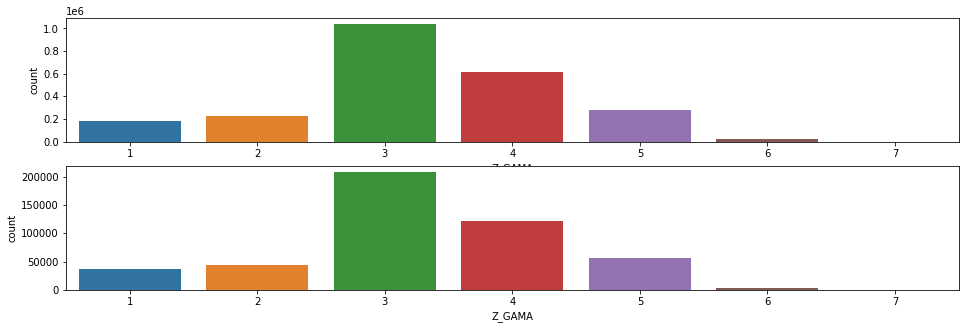

In [28]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 5))
sns.countplot(data=demanda_train, x='Z_GAMA', ax=axes[0]);
sns.countplot(data=demanda_test, x='Z_GAMA', ax=axes[1]);

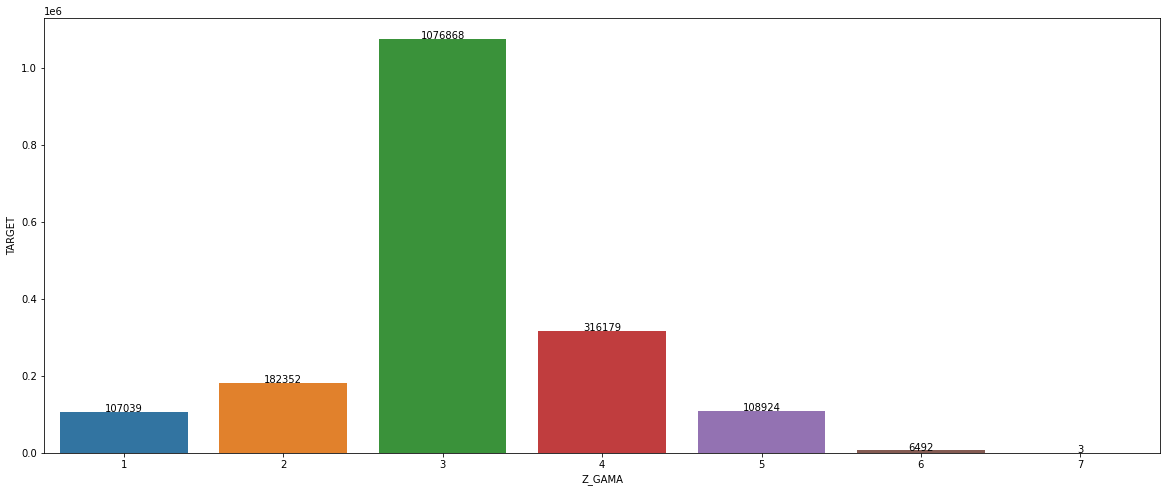

In [29]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

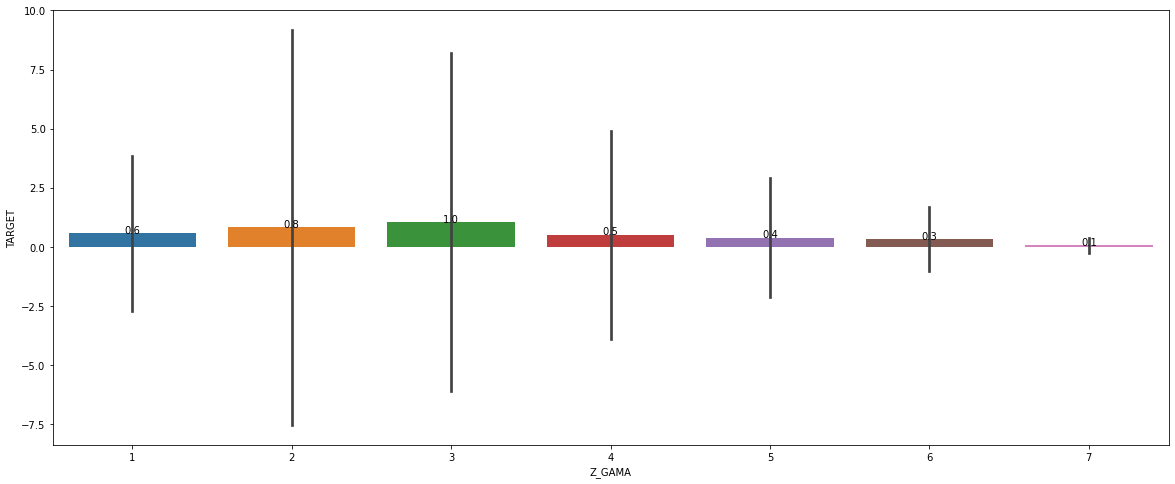

In [30]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

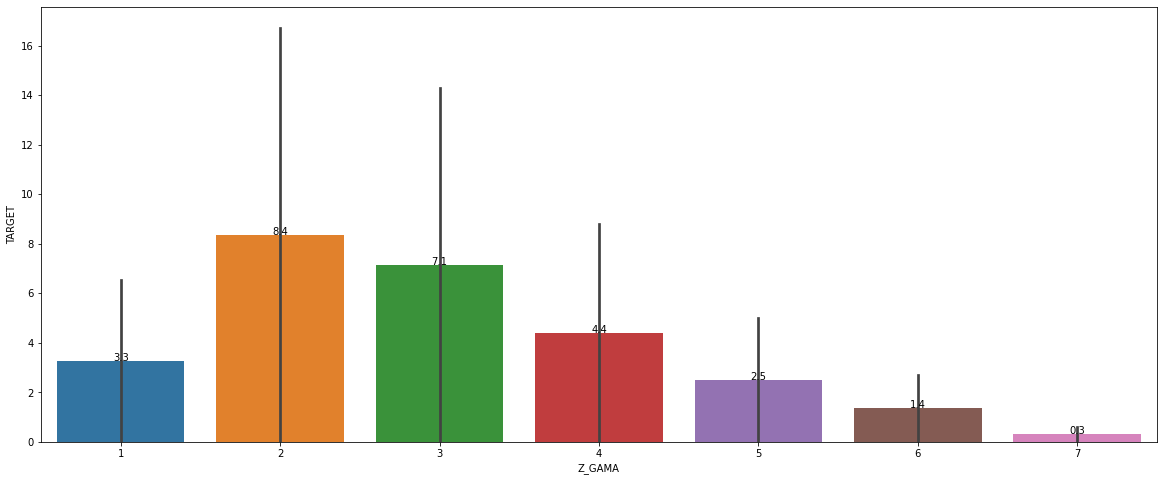

In [31]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.std, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

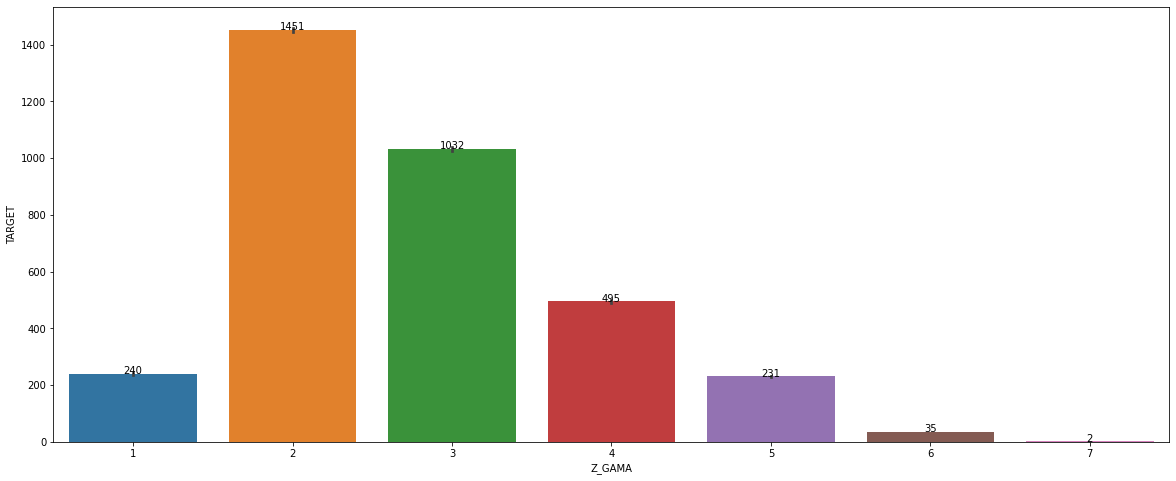

In [32]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='Z_GAMA', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

### Semana_XX

In [33]:
demanda_train['MES_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.strftime('%b'))
demanda_train['ANNIO_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.year)
demanda_train['DIA_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.day)
demanda_train['FECHA_INICIO'] = demanda_train['FECHA_INICIO'].apply(lambda x: x.strftime('%Y-%m-%d'))
demanda_train

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,TARGET,FECHA_INICIO,FECHA_FIN,TARGET_BINARIO,MES_INICIO,ANNIO_INICIO,DIA_INICIO
ID,,,,,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,0,2021-05-17,2021-05-23,0,May,2021,17
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,0,2021-05-24,2021-05-30,0,May,2021,24
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,0,2021-05-31,2021-06-06,0,May,2021,31
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,0,2021-06-07,2021-06-13,0,Jun,2021,7
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,0,2021-06-14,2021-06-20,0,Jun,2021,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_46,17,318,1,24,414,SEMANA_46,0,2022-03-28,2022-04-03,0,Mar,2022,28
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_47,17,318,1,24,414,SEMANA_47,0,2022-04-04,2022-04-10,0,Apr,2022,4
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_48,17,318,1,24,414,SEMANA_48,0,2022-04-11,2022-04-17,0,Apr,2022,11


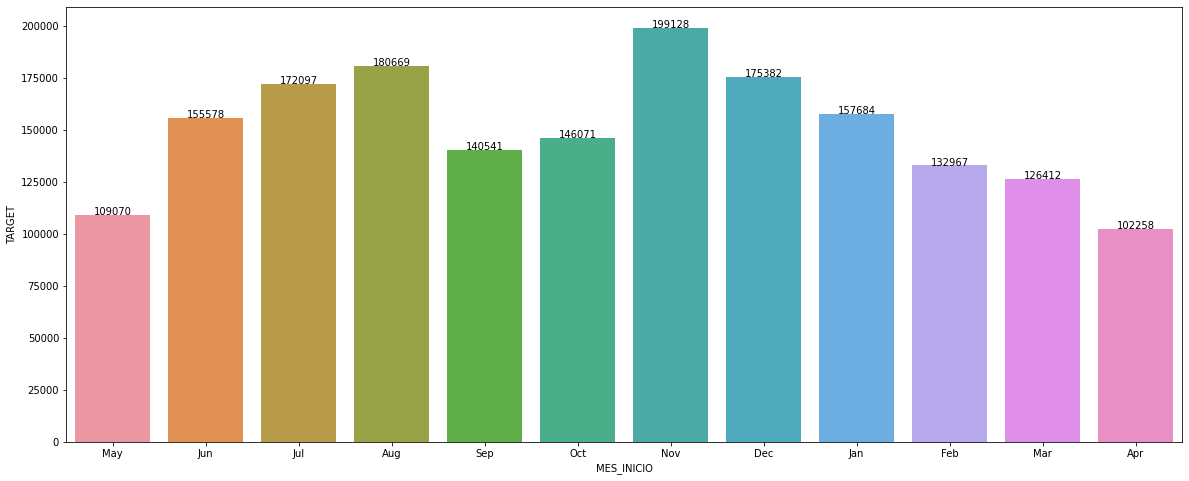

In [34]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='MES_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

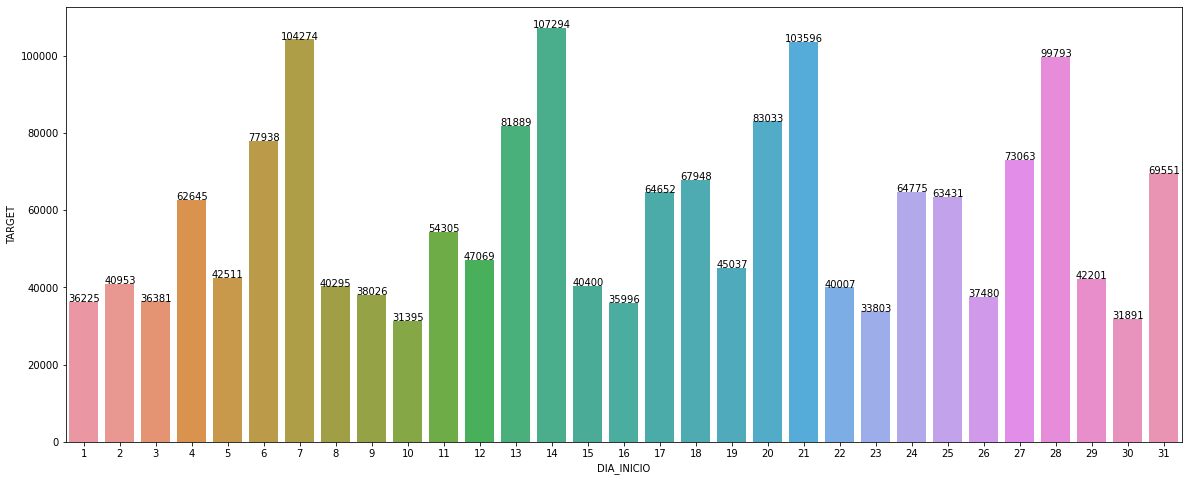

In [35]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='DIA_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
plt.show()

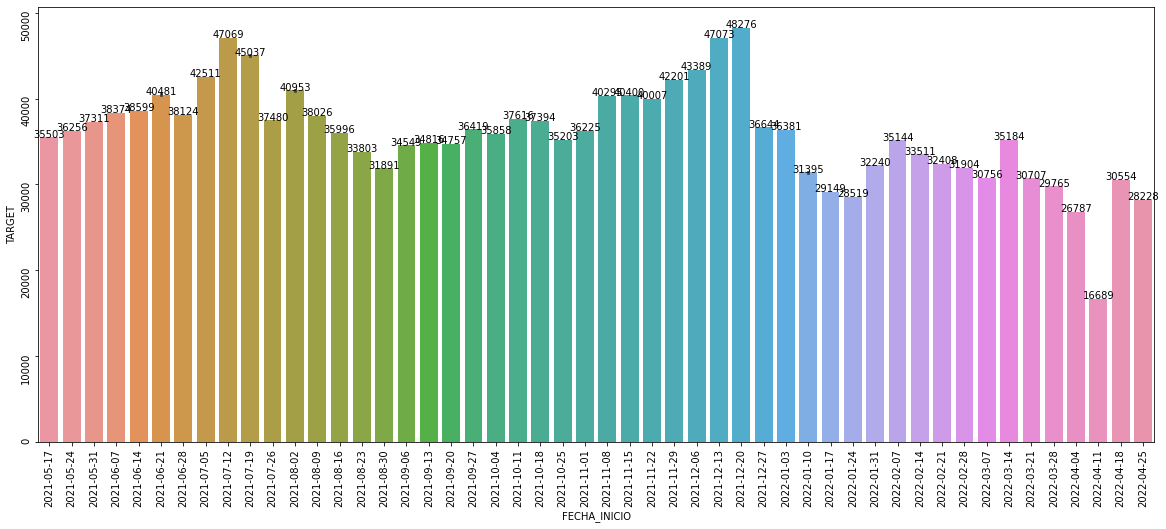

In [36]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='FECHA_INICIO', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
axs.tick_params(rotation=90)
plt.show()

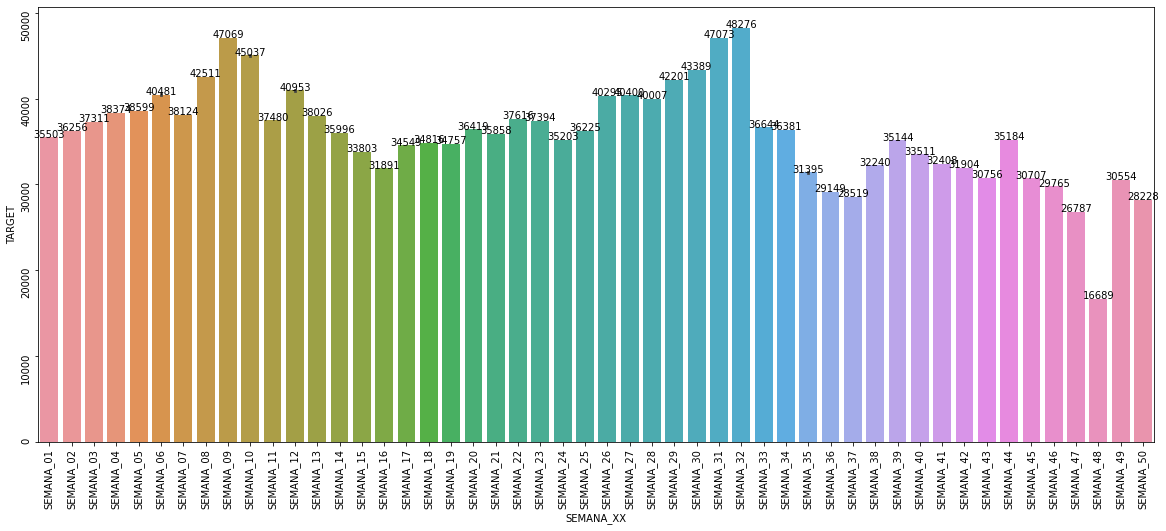

In [37]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.sum, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8)
axs.tick_params(rotation=90)
plt.show()

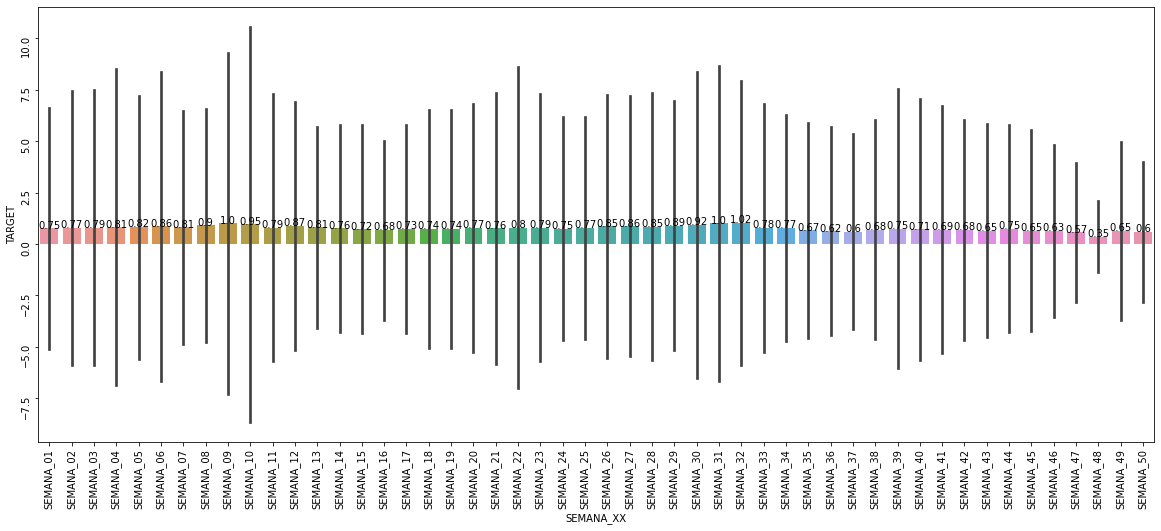

In [38]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.mean, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

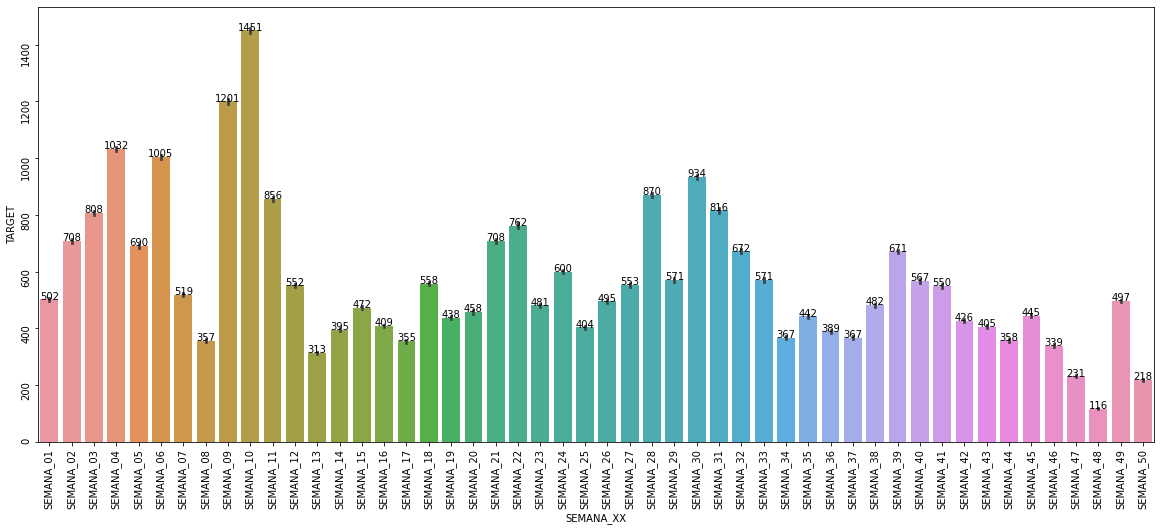

In [39]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.max, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

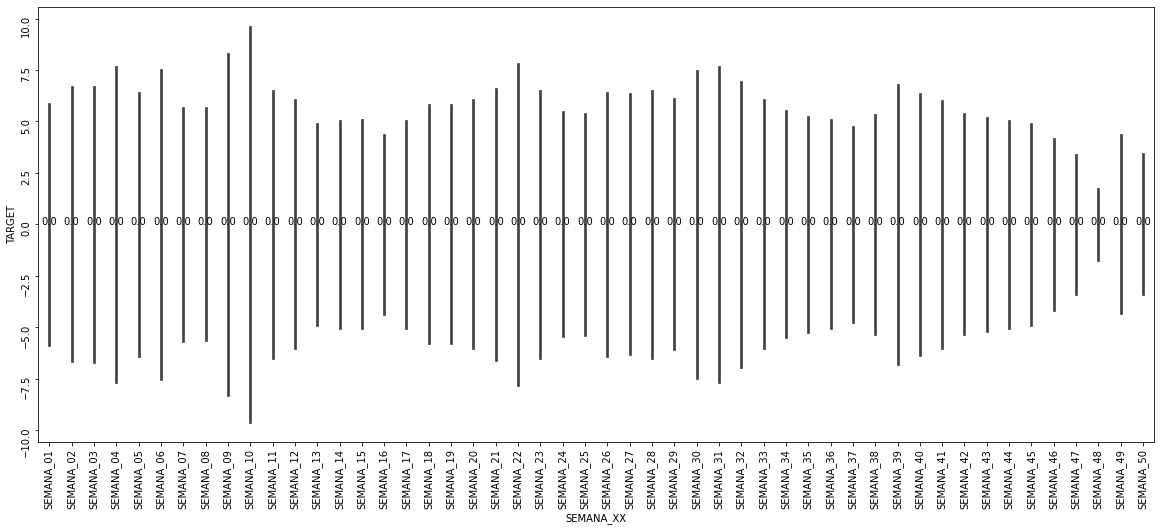

In [40]:
plt.figure(figsize=(20,8))
axs = sns.barplot(x='SEMANA_XX', y='TARGET', data=demanda_train, estimator=np.median, ci='sd');
show_values_on_bars(axs, h_v="v", space=0.8, precision=2)
axs.tick_params(rotation=90)
plt.show()

## FEATURE ENGINEERING

In [162]:
demanda['MES_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.month).astype('int32')
demanda['DIA_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.day).astype('int32')
demanda['ANNIO_INICIO'] = demanda['FECHA_INICIO'].apply(lambda x: x.year).astype('int32')
demanda['MES_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.month).astype('int32')
demanda['DIA_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.day).astype('int32')
demanda['ANNIO_FIN'] = demanda['FECHA_FIN'].apply(lambda x: x.year).astype('int32')
demanda['ANNIO_SEMANA_FIN'] = (demanda['FECHA_FIN'].astype(str).str[:4] + demanda['SEMANA_XX'].str[-2:]).astype('int32')
demanda

,Z_MARCA,Z_MODELO,Z_GAMA,Z_DEPARTAMENTO,Z_PUNTO_VENTA,SEMANA_XX,TARGET,FECHA_INICIO,FECHA_FIN,MES_INICIO,DIA_INICIO,ANNIO_INICIO,MES_FIN,DIA_FIN,ANNIO_FIN,ANNIO_SEMANA_FIN
ID,,,,,,,,,,,,,,,,
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_01,1,1,1,1,1,SEMANA_01,0,2021-05-17,2021-05-23,5,17,2021,5,23,2021,202101
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_02,1,1,1,1,1,SEMANA_02,0,2021-05-24,2021-05-30,5,24,2021,5,30,2021,202102
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_03,1,1,1,1,1,SEMANA_03,0,2021-05-31,2021-06-06,5,31,2021,6,6,2021,202103
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_04,1,1,1,1,1,SEMANA_04,0,2021-06-07,2021-06-13,6,7,2021,6,13,2021,202104
1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1079f498d53d42ff438|0fedacb725c2c2128d2b42505880d91d238e616b926278c41caff6da4c622e51|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_05,1,1,1,1,1,SEMANA_05,0,2021-06-14,2021-06-20,6,14,2021,6,20,2021,202105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_56,17,318,1,24,414,SEMANA_56,-1,2022-06-06,2022-06-12,6,6,2022,6,12,2022,202256
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_57,17,318,1,24,414,SEMANA_57,-1,2022-06-13,2022-06-19,6,13,2022,6,19,2022,202257
ddf2b5328dafe4a5863dc2463578ea789284d9519431204bcd0ab3cb17ac426d|ac45b56f385a5564f090e7afd47d721d3a491796bd3a1230f7c8caa84c5fbc5c|f793de205ead5ac302c4a1627829dea41f176b1068b993a32373fc869918374b|SEMANA_58,17,318,1,24,414,SEMANA_58,-1,2022-06-20,2022-06-26,6,20,2022,6,26,2022,202258


In [163]:
demanda_train = demanda[demanda['TARGET']>=0].copy()

In [164]:
### 
mean_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.mean().to_dict()
mean_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.mean().to_dict()
mean_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.mean().to_dict()
mean_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.mean().to_dict()

###
std_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.std().to_dict()
std_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.std().to_dict()
std_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.std().to_dict()
std_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.std().to_dict()

###
max_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.max().to_dict()
max_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.max().to_dict()
max_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.max().to_dict()
max_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.max().to_dict()

###
sum_encoding_modelo = demanda_train.groupby('Z_MODELO').TARGET.sum().to_dict()
sum_encoding_ptoventa = demanda_train.groupby('Z_PUNTO_VENTA').TARGET.sum().to_dict()
sum_encoding_marca = demanda_train.groupby('Z_MARCA').TARGET.sum().to_dict()
sum_encoding_gama = demanda_train.groupby('Z_GAMA').TARGET.sum().to_dict()

In [165]:
#####
demanda['MODELO_mean_ENC'] = demanda['Z_MODELO'].map(mean_encoding_modelo)
demanda['PTOVENTA_mean_ENC'] = demanda['Z_PUNTO_VENTA'].map(mean_encoding_ptoventa)
demanda['MARCA_mean_ENC'] = demanda['Z_MARCA'].map(mean_encoding_marca)
demanda['GAMA_mean_ENC'] = demanda['Z_GAMA'].map(mean_encoding_gama)

#####
demanda['MODELO_std_ENC'] = demanda['Z_MODELO'].map(std_encoding_modelo)
demanda['PTOVENTA_std_ENC'] = demanda['Z_PUNTO_VENTA'].map(std_encoding_ptoventa)
demanda['MARCA_std_ENC'] = demanda['Z_MARCA'].map(std_encoding_marca)
demanda['GAMA_std_ENC'] = demanda['Z_GAMA'].map(std_encoding_gama)

#####
demanda['MODELO_max_ENC'] = demanda['Z_MODELO'].map(max_encoding_modelo)
demanda['PTOVENTA_max_ENC'] = demanda['Z_PUNTO_VENTA'].map(max_encoding_ptoventa)
demanda['MARCA_max_ENC'] = demanda['Z_MARCA'].map(max_encoding_marca)
demanda['GAMA_max_ENC'] = demanda['Z_GAMA'].map(max_encoding_gama)

#####
demanda['MODELO_sum_ENC'] = demanda['Z_MODELO'].map(sum_encoding_modelo)
demanda['PTOVENTA_sum_ENC'] = demanda['Z_PUNTO_VENTA'].map(sum_encoding_ptoventa)
demanda['MARCA_sum_ENC'] = demanda['Z_MARCA'].map(sum_encoding_marca)
demanda['GAMA_sum_ENC'] = demanda['Z_GAMA'].map(sum_encoding_gama)

In [166]:
demanda['PORC_MODELO_mean_max_ENC'] = demanda['MODELO_mean_ENC']/demanda['MODELO_max_ENC'] 
demanda['PORC_PTOVENTA_mean_max_ENC'] = demanda['PTOVENTA_mean_ENC']/demanda['PTOVENTA_max_ENC'] 
demanda['PORC_MARCA_mean_max_ENC'] = demanda['MARCA_mean_ENC']/demanda['MARCA_max_ENC']
demanda['PORC_GAMA_mean_max_ENC'] = demanda['GAMA_mean_ENC']/demanda['GAMA_max_ENC'] 

In [167]:
# demanda.drop(['PORC_MODELO_sum_mean_ENC',
#        'PORC_PTOVENTA_sum_mean_ENC', 'PORC_MARCA_sum_mean_ENC',
#        'PORC_GAMA_sum_mean_ENC'], axis=1, inplace=True)
# demanda.shape
# demanda.drop(['PORC_MODELO_max_sum_ENC',
#        'PORC_PTOVENTA_max_sum_ENC', 'PORC_MARCA_max_sum_ENC',
#        'PORC_GAMA_max_sum_ENC'], axis=1, inplace=True)
# demanda.shape

In [168]:
# demanda['PORC_MODELO_max_std_ENC'] = demanda['MODELO_max_ENC']/demanda['MODELO_std_ENC'] 
# demanda['PORC_PTOVENTA_max_std_ENC'] = demanda['PTOVENTA_max_ENC']/demanda['PTOVENTA_std_ENC'] 
# demanda['PORC_MARCA_max_std_ENC'] = demanda['MARCA_max_ENC']/demanda['MARCA_std_ENC']
# demanda['PORC_GAMA_max_std_ENC'] = demanda['GAMA_max_ENC']/demanda['GAMA_std_ENC'] 

In [169]:
# def get_one_hot(df, feature):
#     one_hot = pd.get_dummies(df[feature])
#     one_hot.columns = [feature+'_'+str(i) for i in one_hot.columns]
#     return one_hot
# one_hot_departamento = get_one_hot(demanda, 'Z_DEPARTAMENTO')
# demanda = pd.concat([demanda, one_hot_departamento], axis=1)

In [170]:
# demanda.drop(['MODELO_sum_ENC','PTOVENTA_sum_ENC','MARCA_sum_ENC','GAMA_sum_ENC'], axis=1, inplace=True)

In [171]:
### Drop Columns
demanda2 = demanda.copy()
drop_columns =['Z_MARCA','Z_GAMA','Z_MODELO','Z_PUNTO_VENTA','Z_DEPARTAMENTO',
              'FECHA_INICIO','FECHA_FIN']
demanda2.drop(drop_columns, axis=1, inplace=True)
demanda2.columns

Index(['SEMANA_XX', 'TARGET', 'MES_INICIO', 'DIA_INICIO', 'ANNIO_INICIO',
       'MES_FIN', 'DIA_FIN', 'ANNIO_FIN', 'ANNIO_SEMANA_FIN',
       'MODELO_mean_ENC', 'PTOVENTA_mean_ENC', 'MARCA_mean_ENC',
       'GAMA_mean_ENC', 'MODELO_std_ENC', 'PTOVENTA_std_ENC', 'MARCA_std_ENC',
       'GAMA_std_ENC', 'MODELO_max_ENC', 'PTOVENTA_max_ENC', 'MARCA_max_ENC',
       'GAMA_max_ENC', 'MODELO_sum_ENC', 'PTOVENTA_sum_ENC', 'MARCA_sum_ENC',
       'GAMA_sum_ENC', 'PORC_MODELO_mean_max_ENC',
       'PORC_PTOVENTA_mean_max_ENC', 'PORC_MARCA_mean_max_ENC',
       'PORC_GAMA_mean_max_ENC'],
      dtype='object')

In [172]:
demanda2.isna().sum()

SEMANA_XX                         0
TARGET                            0
MES_INICIO                        0
DIA_INICIO                        0
ANNIO_INICIO                      0
MES_FIN                           0
DIA_FIN                           0
ANNIO_FIN                         0
ANNIO_SEMANA_FIN                  0
MODELO_mean_ENC                   0
PTOVENTA_mean_ENC                 0
MARCA_mean_ENC                    0
GAMA_mean_ENC                     0
MODELO_std_ENC                    0
PTOVENTA_std_ENC                  0
MARCA_std_ENC                     0
GAMA_std_ENC                      0
MODELO_max_ENC                    0
PTOVENTA_max_ENC                  0
MARCA_max_ENC                     0
GAMA_max_ENC                      0
MODELO_sum_ENC                    0
PTOVENTA_sum_ENC                  0
MARCA_sum_ENC                     0
GAMA_sum_ENC                      0
PORC_MODELO_mean_max_ENC      95460
PORC_PTOVENTA_mean_max_ENC     5040
PORC_MARCA_mean_max_ENC     

## ENTRENAMIENTO 

In [173]:
demanda2['SEMANA_XX'] = demanda2['SEMANA_XX'].astype(str).str[-2:].astype('int32')

In [174]:
y_train = demanda2[demanda2['TARGET']>=0][['TARGET']].copy()
train = demanda2[demanda2['TARGET']>=0].copy()
test = demanda2[demanda2['TARGET']<0].copy()
train.shape, test.shape, y_train.shape

((2358650, 29), (471730, 29), (2358650, 1))

In [175]:
train.isna().sum()

SEMANA_XX                         0
TARGET                            0
MES_INICIO                        0
DIA_INICIO                        0
ANNIO_INICIO                      0
MES_FIN                           0
DIA_FIN                           0
ANNIO_FIN                         0
ANNIO_SEMANA_FIN                  0
MODELO_mean_ENC                   0
PTOVENTA_mean_ENC                 0
MARCA_mean_ENC                    0
GAMA_mean_ENC                     0
MODELO_std_ENC                    0
PTOVENTA_std_ENC                  0
MARCA_std_ENC                     0
GAMA_std_ENC                      0
MODELO_max_ENC                    0
PTOVENTA_max_ENC                  0
MARCA_max_ENC                     0
GAMA_max_ENC                      0
MODELO_sum_ENC                    0
PTOVENTA_sum_ENC                  0
MARCA_sum_ENC                     0
GAMA_sum_ENC                      0
PORC_MODELO_mean_max_ENC      79550
PORC_PTOVENTA_mean_max_ENC     4200
PORC_MARCA_mean_max_ENC     

In [176]:
folds = []
folds.append(list(train[(train['SEMANA_XX']>=1) & (train['SEMANA_XX']<=10)].index))
folds.append(list(train[(train['SEMANA_XX']>=11) & (train['SEMANA_XX']<=20)].index))
folds.append(list(train[(train['SEMANA_XX']>=21) & (train['SEMANA_XX']<=30)].index))
folds.append(list(train[(train['SEMANA_XX']>=31) & (train['SEMANA_XX']<=40)].index))
folds.append(list(train[(train['SEMANA_XX']>=41) & (train['SEMANA_XX']<=50)].index))
len(folds), len(folds[0])

(5, 471730)

In [177]:
np.save('../data/folds.npy', folds)

In [178]:
train.drop(['SEMANA_XX', 'TARGET'], axis=1, inplace=True)
test.drop(['SEMANA_XX', 'TARGET'], axis=1, inplace=True)
train.shape, test.shape

((2358650, 27), (471730, 27))

In [179]:
demanda2.to_pickle('../data/preprocessed/demanda2.pkl')
train.to_pickle('../data/preprocessed/train.pkl')
test.to_pickle('../data/preprocessed/test.pkl')
y_train.to_pickle('../data/preprocessed/y_train.pkl')

## CATBOOST

In [208]:
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import ParameterGrid
params = ParameterGrid({"max_depth":[10], "learning_rate":[0.2], 'loss_function':['RMSE']})
for param in params:
    print(param)
    fi = []
    test_probs = []
    train_probs = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.drop(idx)
        yt = y_train.loc[Xt.index].TARGET

        Xv = train.loc[idx]
        yv = y_train.loc[Xv.index].TARGET

        learner = CatBoostRegressor(**param, n_estimators=1000, eval_metric = 'RMSE', random_state=42)
        # learner = CatBoostRegressor(max_depth=9, n_estimators=1000,  eval_metric = 'RMSE', random_state=42, )
        # learner = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, )

        learner.fit(Xt, yt,  early_stopping_rounds=10, 
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=100)

        test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

    train_probs = pd.concat(train_probs)
    train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

    fi = pd.concat(fi, axis=1).mean(axis=1)
    score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)

    print('SCORE RMSE: ', score)

{'learning_rate': 0.2, 'max_depth': 10}
********** 0 **********
0:	learn: 5.1524069	test: 5.1524069	test1: 6.7117720	best: 6.7117720 (0)	total: 750ms	remaining: 12m 29s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 4.689349272
bestIteration = 39

Shrink model to first 40 iterations.
********** 1 **********
0:	learn: 5.5626704	test: 5.5626704	test1: 5.0114898	best: 5.0114898 (0)	total: 775ms	remaining: 12m 54s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.595264662
bestIteration = 9

Shrink model to first 10 iterations.
********** 2 **********
0:	learn: 5.3035901	test: 5.3035901	test1: 6.0705929	best: 6.0705929 (0)	total: 724ms	remaining: 12m 3s
100:	learn: 2.0555261	test: 2.0555261	test1: 3.8521622	best: 3.8487993 (94)	total: 1m 13s	remaining: 10m 54s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.848799299
bestIteration = 94

Shrink model to first 95 iterations.
********** 3 **********
0:	learn: 5.4263624	test: 5.4263624	t

In [209]:
train_probs.name='probs_cb'
test_probs.name='probs_cb'
train_probs.to_pickle('../data/preprocessed/catboost/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/catboost/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/catboost/fi.pkl')

#### Visualizacion de resultados

In [210]:
fi.sort_values(ascending=False)

ANNIO_SEMANA_FIN              0.152072
PTOVENTA_sum_ENC              0.139398
MODELO_sum_ENC                0.134824
PTOVENTA_max_ENC              0.080638
MODELO_mean_ENC               0.068091
MODELO_std_ENC                0.066142
PORC_MODELO_mean_max_ENC      0.053515
PTOVENTA_mean_ENC             0.051645
MES_INICIO                    0.043034
MODELO_max_ENC                0.040175
PTOVENTA_std_ENC              0.038193
GAMA_sum_ENC                  0.023728
MES_FIN                       0.021777
PORC_MARCA_mean_max_ENC       0.019577
PORC_PTOVENTA_mean_max_ENC    0.012985
GAMA_mean_ENC                 0.011892
MARCA_max_ENC                 0.010183
MARCA_mean_ENC                0.010029
MARCA_std_ENC                 0.005139
GAMA_std_ENC                  0.003839
DIA_FIN                       0.003529
MARCA_sum_ENC                 0.002882
DIA_INICIO                    0.002190
GAMA_max_ENC                  0.002183
ANNIO_INICIO                  0.001557
PORC_GAMA_mean_max_ENC   

In [211]:
test_probs.sort_values().unique()

array([0.00000000e+00, 1.27803140e-05, 3.61404979e-05, ...,
       1.79816001e+02, 1.89409759e+02, 1.96127335e+02])

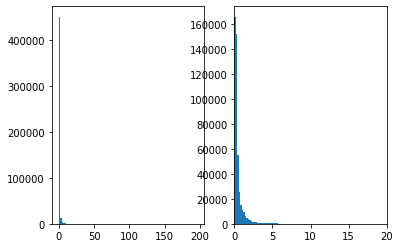

In [212]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

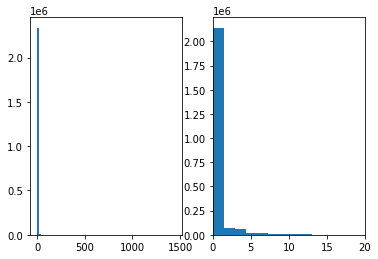

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [214]:
test_probs.describe()

count    471730.000000
mean          0.627157
std           2.331713
min           0.000000
25%           0.167122
50%           0.253494
75%           0.502514
max         196.127335
Name: probs_cb, dtype: float64

In [215]:
test_probs_cb = test_probs.copy()

## LIGHT GBM

In [217]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import ParameterGrid
#colsample_bytree
# subsample
# params = ParameterGrid({"max_depth":[12, 14], "learning_rate":[0.166414, 0.05, 0.1, 0.2]})
params = ParameterGrid({"colsample_bytree":[ 1.0], 'subsample':[1.0], 'boosting_type':['gbdt'],
                        'max_depth':[18], 'learning_rate':[0.2], 'importance_type':['gain'], 'num_leaves':[100], 'min_split_gain':[0.1] })
for param in params:
    fi = []
    test_probs = []
    train_probs = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.drop(idx)
        yt = y_train.loc[Xt.index].TARGET

        Xv = train.loc[idx]
        yv = y_train.loc[Xv.index].TARGET

        learner = LGBMRegressor(n_estimators=1000,  random_state=42, n_jobs=-1, **param)
        # learner = LGBMRegressor(n_estimators=1000,  random_state=42)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

        test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

    train_probs = pd.concat(train_probs)
    train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

    fi = pd.concat(fi, axis=1).mean(axis=1)
    score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)
    print(param)
    print('SCORE RMSE: ', score)

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 2.92788	training's l2: 8.57248	valid_1's rmse: 5.31857	valid_1's l2: 28.2872
[20]	training's rmse: 2.4708	training's l2: 6.10484	valid_1's rmse: 4.98737	valid_1's l2: 24.8738
[30]	training's rmse: 2.28156	training's l2: 5.2055	valid_1's rmse: 4.84265	valid_1's l2: 23.4513
[40]	training's rmse: 2.14537	training's l2: 4.60259	valid_1's rmse: 4.74052	valid_1's l2: 22.4725
[50]	training's rmse: 2.05159	training's l2: 4.20901	valid_1's rmse: 4.67957	valid_1's l2: 21.8984
[60]	training's rmse: 1.97995	training's l2: 3.92018	valid_1's rmse: 4.65851	valid_1's l2: 21.7017
[70]	training's rmse: 1.9187	training's l2: 3.68141	valid_1's rmse: 4.63926	valid_1's l2: 21.5227
[80]	training's rmse: 1.87265	training's l2: 3.50683	valid_1's rmse: 4.61192	valid_1's l2: 21.2698
[90]	training's rmse: 1.83622	training's l2: 3.3717	valid_1's rmse: 4.61761	valid_1's l2: 21.3223
********** 1 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.25862	training's l2: 10.6186	valid_1's rmse: 3.50845	valid_1's l2: 12.3092
[20]	training's rmse: 2.70737	training's l2: 7.32984	valid_1's rmse: 3.63275	valid_1's l2: 13.1969
********** 2 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.02667	training's l2: 9.16071	valid_1's rmse: 4.51978	valid_1's l2: 20.4284
[20]	training's rmse: 2.56941	training's l2: 6.60185	valid_1's rmse: 4.31964	valid_1's l2: 18.6593
[30]	training's rmse: 2.35304	training's l2: 5.53681	valid_1's rmse: 4.26168	valid_1's l2: 18.1619
[40]	training's rmse: 2.20952	training's l2: 4.88197	valid_1's rmse: 4.20603	valid_1's l2: 17.6906
[50]	training's rmse: 2.08741	training's l2: 4.3573	valid_1's rmse: 4.13633	valid_1's l2: 17.1092
[60]	training's rmse: 2.02306	training's l2: 4.09278	valid_1's rmse: 4.12658	valid_1's l2: 17.0287
[70]	training's rmse: 1.95566	training's l2: 3.82462	valid_1's rmse: 4.09601	valid_1's l2: 16.7773
[80]	training's rmse: 1.90362	training's l2: 3.62378	valid_1's rmse: 4.08541	valid_1's l2: 16.6906
[90]	training's rmse: 1.87654	training's l2: 3.5214	valid_1's rmse: 4.07751	valid_1's l2: 16.6261
[100]	training's rmse: 1.82304	training's l2: 3.32347	valid_1's rmse: 4.075	valid_1's l2: 16.6056
[110]	trainin

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.15533	training's l2: 9.95608	valid_1's rmse: 3.8955	valid_1's l2: 15.1749
[20]	training's rmse: 2.67386	training's l2: 7.14954	valid_1's rmse: 3.74232	valid_1's l2: 14.005
[30]	training's rmse: 2.42447	training's l2: 5.87804	valid_1's rmse: 3.66931	valid_1's l2: 13.4638
[40]	training's rmse: 2.26227	training's l2: 5.11786	valid_1's rmse: 3.62248	valid_1's l2: 13.1224
[50]	training's rmse: 2.17761	training's l2: 4.74197	valid_1's rmse: 3.59888	valid_1's l2: 12.952
[60]	training's rmse: 2.07484	training's l2: 4.30497	valid_1's rmse: 3.6016	valid_1's l2: 12.9715
********** 4 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 3.26929	training's l2: 10.6883	valid_1's rmse: 3.9792	valid_1's l2: 15.8341
{'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'importance_type': 'gain', 'learning_rate': 0.2, 'max_depth': 18, 'min_split_gain': 0.1, 'num_leaves': 100, 'subsample': 1.0}
SCORE RMSE:  3.9194379462432867


In [218]:
train_probs.name='probs_lg'
test_probs.name='probs_lg'
train_probs.to_pickle('../data/preprocessed/lightgbm/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/lightgbm/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/lightgbm/fi.pkl')

#### Visualizacion de resultados

In [219]:
fi.sort_values(ascending=False)

PTOVENTA_mean_ENC             2.515817e-01
MODELO_mean_ENC               2.336269e-01
ANNIO_SEMANA_FIN              1.502055e-01
MODELO_std_ENC                6.988628e-02
PTOVENTA_std_ENC              5.087601e-02
MES_INICIO                    4.654483e-02
MODELO_sum_ENC                4.220462e-02
MODELO_max_ENC                2.416106e-02
PORC_MODELO_mean_max_ENC      2.394149e-02
MARCA_mean_ENC                2.352306e-02
MES_FIN                       2.277433e-02
PTOVENTA_sum_ENC              2.141656e-02
GAMA_mean_ENC                 1.612706e-02
DIA_FIN                       6.188325e-03
PTOVENTA_max_ENC              5.064710e-03
DIA_INICIO                    4.667130e-03
MARCA_sum_ENC                 3.543172e-03
PORC_PTOVENTA_mean_max_ENC    2.368891e-03
MARCA_max_ENC                 3.378570e-04
MARCA_std_ENC                 2.764406e-04
PORC_MARCA_mean_max_ENC       2.297295e-04
GAMA_std_ENC                  2.003289e-04
ANNIO_FIN                     1.310391e-04
GAMA_sum_EN

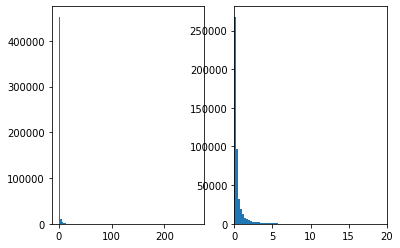

In [220]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

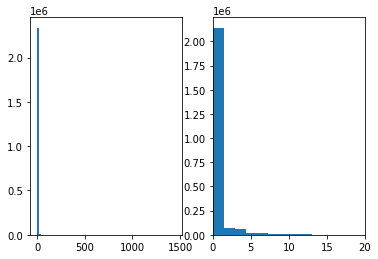

In [221]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [222]:
test_probs.describe()

count    471730.000000
mean          0.676502
std           2.796188
min           0.000000
25%           0.155151
50%           0.227832
75%           0.473868
max         262.218624
Name: probs_lg, dtype: float64

In [223]:
test_probs_lg = test_probs.copy()

## XGBOOST

In [52]:
from sklearn.metrics import mean_squared_error
from xgboost  import XGBRegressor
from sklearn.model_selection import ParameterGrid
# params = ParameterGrid({"max_depth":[ 7,9, 14], 'colsample_bytree':[0.8, 1],'min_child_samples':[1500, 1000]})
# for param in params:
#     print(param)

fi = []
test_probs = []
train_probs = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.drop(idx)
    yt = y_train.loc[Xt.index].TARGET

    Xv = train.loc[idx]
    yv = y_train.loc[Xv.index].TARGET

    # learner = XGBRegressor(n_estimators=1000,  random_state=42, **param)
    learner = XGBRegressor(n_estimators=1000,  random_state=42)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

    test_probs.append(pd.Series(learner.predict(test), index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict(Xv), index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
test_probs = test_probs.apply(lambda x: 0 if x<0 else x)

train_probs = pd.concat(train_probs)
train_probs = train_probs.apply(lambda x: 0 if x<0 else x)

fi = pd.concat(fi, axis=1).mean(axis=1)
score = mean_squared_error(y_train.loc[train.index].TARGET, train_probs.loc[train.index], squared=False)
print('SCORE RMSE: ', score)

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:4.93076	validation_1-rmse:6.59096
[10]	validation_0-rmse:3.31274	validation_1-rmse:5.33756
[20]	validation_0-rmse:2.80699	validation_1-rmse:4.94459
[30]	validation_0-rmse:2.57792	validation_1-rmse:4.90011
[36]	validation_0-rmse:2.49021	validation_1-rmse:4.87800
********** 1 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.29125	validation_1-rmse:4.58103
[10]	validation_0-rmse:3.57271	validation_1-rmse:4.06835
[13]	validation_0-rmse:3.35575	validation_1-rmse:3.97287
********** 2 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:4.99563	validation_1-rmse:5.88470
[10]	validation_0-rmse:3.26980	validation_1-rmse:4.66945
[20]	validation_0-rmse:2.78074	validation_1-rmse:4.27645
[30]	validation_0-rmse:2.53870	validation_1-rmse:4.13315
[40]	validation_0-rmse:2.36012	validation_1-rmse:4.09087
[50]	validation_0-rmse:2.24387	validation_1-rmse:4.04560
[60]	validation_0-rmse:2.13394	validation_1-rmse:4.03812
[70]	validation_0-rmse:2.07440	validation_1-rmse:4.02081
[80]	validation_0-rmse:2.01457	validation_1-rmse:4.02231
[90]	validation_0-rmse:1.96332	validation_1-rmse:4.02781
[95]	validation_0-rmse:1.94921	validation_1-rmse:4.02765
********** 3 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.20530	validation_1-rmse:5.45150
[10]	validation_0-rmse:3.33663	validation_1-rmse:4.26290
[20]	validation_0-rmse:2.89753	validation_1-rmse:4.04595
[30]	validation_0-rmse:2.63761	validation_1-rmse:3.89807
[40]	validation_0-rmse:2.44110	validation_1-rmse:3.78925
[50]	validation_0-rmse:2.35801	validation_1-rmse:3.78130
[60]	validation_0-rmse:2.22925	validation_1-rmse:3.74614
[70]	validation_0-rmse:2.13363	validation_1-rmse:3.71275
[80]	validation_0-rmse:2.05747	validation_1-rmse:3.71710
[84]	validation_0-rmse:2.03671	validation_1-rmse:3.72650
********** 4 **********


C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:5.35150	validation_1-rmse:3.98367
[10]	validation_0-rmse:3.27981	validation_1-rmse:4.35450
[12]	validation_0-rmse:3.17891	validation_1-rmse:4.39185
SCORE RMSE:  4.065513402050455


In [53]:
train_probs.name='probs_xg'
test_probs.name='probs_xg'
train_probs.to_pickle('../data/preprocessed/xgboost/train_probs.pkl')
test_probs.to_pickle('../data/preprocessed/xgboost/test_probs.pkl')
fi.sort_values(ascending=False).to_pickle('../data/preprocessed/xgboost/fi.pkl')

#### Visualizacion de resultados

In [54]:
fi.sort_values(ascending=False)

PTOVENTA_mean_ENC             0.137992
PTOVENTA_std_ENC              0.091402
MODELO_mean_ENC               0.088907
MODELO_std_ENC                0.084623
ANNIO_SEMANA_FIN              0.064006
MARCA_mean_ENC                0.061534
GAMA_mean_ENC                 0.056696
MODELO_sum_ENC                0.056157
MES_INICIO                    0.048797
PORC_MODELO_mean_max_ENC      0.045946
MARCA_sum_ENC                 0.044286
MES_FIN                       0.029628
DIA_FIN                       0.029355
MODELO_max_ENC                0.025336
PTOVENTA_sum_ENC              0.024577
MARCA_std_ENC                 0.023049
ANNIO_FIN                     0.019051
DIA_INICIO                    0.019020
PTOVENTA_max_ENC              0.014875
GAMA_std_ENC                  0.013358
MARCA_max_ENC                 0.008393
PORC_PTOVENTA_mean_max_ENC    0.005018
GAMA_sum_ENC                  0.004052
PORC_MARCA_mean_max_ENC       0.003941
GAMA_max_ENC                  0.000000
ANNIO_INICIO             

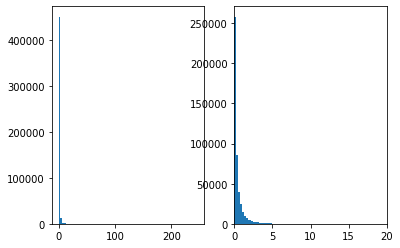

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test_probs, bins=100);
ax2.hist(test_probs, bins=1000);
plt.xlim(0,20);

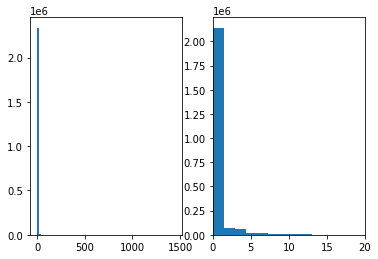

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [57]:
test_probs.describe()

count    471730.000000
mean          0.665456
std           2.683209
min           0.000000
25%           0.118661
50%           0.211416
75%           0.541224
max         245.842499
Name: probs_xg, dtype: float64

In [58]:
test_probs_xg = test_probs.copy()

## SUBMISION

In [59]:
test_probs_cb.describe(), test_probs_lg.describe(), test_probs_xg.describe()

(count    471730.000000
 mean          0.651709
 std           2.406563
 min           0.000000
 25%           0.140276
 50%           0.232728
 75%           0.541590
 max         182.778139
 Name: probs_cb, dtype: float64,
 count    471730.000000
 mean          0.668253
 std           2.529192
 min           0.000000
 25%           0.193463
 50%           0.276110
 75%           0.502135
 max         228.225275
 Name: probs_lg, dtype: float64,
 count    471730.000000
 mean          0.665456
 std           2.683209
 min           0.000000
 25%           0.118661
 50%           0.211416
 75%           0.541224
 max         245.842499
 Name: probs_xg, dtype: float64)

In [60]:
# test_probs = test_probs_lg.copy()
# test_probs.name = 'Demanda'
# test_submit = test_probs.reset_index()[['ID','Demanda']]
# test_submit

In [61]:
# test_submit['Demanda'].describe()

In [62]:
# test_submit.to_csv('../results/test.csv', index=False)

In [63]:
# !kaggle competitions submit datathon-entel-2022-reto2 -f ../results/test.csv -m "test"

## Entrenamiento con toda la data

In [224]:
punto_corte = 202240
Xt = train[train['ANNIO_SEMANA_FIN']<=punto_corte]
Xv = train[train['ANNIO_SEMANA_FIN']>punto_corte]
yt = y_train.loc[Xt.index]['TARGET']
yv = y_train.loc[Xv.index]['TARGET']
Xt.shape, yt.shape, Xv.shape, yv.shape

((1886920, 27), (1886920,), (471730, 27), (471730,))

In [225]:
from catboost import CatBoostRegressor
# learner = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, **result_tunning["param"])
learner = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, )
learner.fit(Xt, yt,  early_stopping_rounds=10, 
            eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

Learning rate set to 0.166414
0:	learn: 5.8831309	test: 5.8831309	test1: 4.2591336	best: 4.2591336 (0)	total: 260ms	remaining: 4m 19s
10:	learn: 4.4832471	test: 4.4832471	test1: 4.0149651	best: 3.9233976 (6)	total: 2.54s	remaining: 3m 48s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 3.923397616
bestIteration = 6

Shrink model to first 7 iterations.


In [226]:
from lightgbm import LGBMRegressor
# learner = LGBMRegressor(n_estimators=1000,  random_state=42, **result_tunning["param"]) 
learner = LGBMRegressor(n_estimators=1000,  random_state=42)
learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
            eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_entel2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's rmse: 4.39442	training's l2: 19.311	valid_1's rmse: 3.86884	valid_1's l2: 14.968
[20]	training's rmse: 3.81619	training's l2: 14.5633	valid_1's rmse: 3.95533	valid_1's l2: 15.6446


LGBMRegressor(n_estimators=1000, random_state=42)

In [227]:
# %%time
# from xgboost import XGBRegressor
# # learner = XGBRegressor(n_estimators=1000,  random_state=42, **result_tunning["param"]) 
# learner = XGBRegressor(n_estimators=1000,  random_state=42)
# learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="rmse",
#             eval_set=[(Xt, yt), (Xv, yv)], verbose=10)

In [231]:
%%time
learner_cb = CatBoostRegressor(n_estimators=1000, eval_metric = 'RMSE', random_state=42, max_depth=10, learning_rate=0.2)
learner_cb.fit(train, y_train, verbose = 100)

0:	learn: 5.4258028	total: 920ms	remaining: 15m 19s
100:	learn: 2.2021707	total: 1m 29s	remaining: 13m 18s
200:	learn: 1.8692638	total: 2m 59s	remaining: 11m 52s
300:	learn: 1.7257070	total: 4m 28s	remaining: 10m 23s
400:	learn: 1.6210994	total: 5m 57s	remaining: 8m 54s
500:	learn: 1.5470672	total: 7m 27s	remaining: 7m 25s
600:	learn: 1.4997060	total: 8m 56s	remaining: 5m 56s
700:	learn: 1.4549511	total: 10m 26s	remaining: 4m 27s
800:	learn: 1.4178822	total: 11m 56s	remaining: 2m 57s
900:	learn: 1.3858691	total: 13m 25s	remaining: 1m 28s
999:	learn: 1.3573080	total: 14m 54s	remaining: 0us
CPU times: total: 1h 36min 56s
Wall time: 14min 55s


In [232]:
%%time
learner_lg = LGBMRegressor(n_estimators=1000,  random_state=42, max_depth=18, learning_rate=0.2,  importance_type='gain',
                          num_leaves=100, min_split_gain=0.1, n_job=-1)
learner_lg.fit(train, y_train, eval_metric="rmse",  verbose = 100)

CPU times: total: 9min 42s
Wall time: 1min 18s


LGBMRegressor(importance_type='gain', learning_rate=0.2, max_depth=18,
              min_split_gain=0.1, n_estimators=1000, n_job=-1, num_leaves=100,
              random_state=42)

In [233]:
# %%time
# learner_xg = XGBRegressor(n_estimators=1000,  random_state=42)
# learner_xg.fit(train, y_train, eval_metric="rmse",  verbose = 100)

### Visualizacion Resultados

In [234]:
features_importances = pd.Series(learner_cb.feature_importances_ / learner_cb.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 27
variables con importancia acumulada al 99% : 20
variables con zero importancia : 1


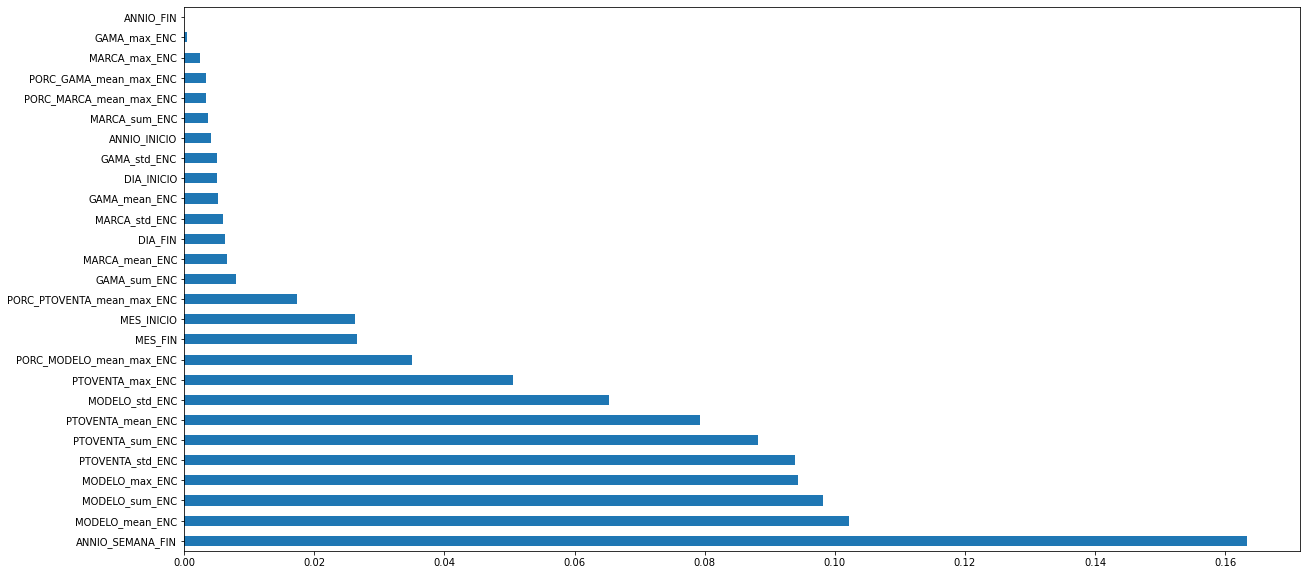

In [117]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

In [235]:
features_importances = pd.Series(learner_lg.feature_importances_ / learner_lg.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
_, _ = get_feature_selection(features_importances)

total de variables : 27
variables con importancia acumulada al 99% : 16
variables con zero importancia : 2


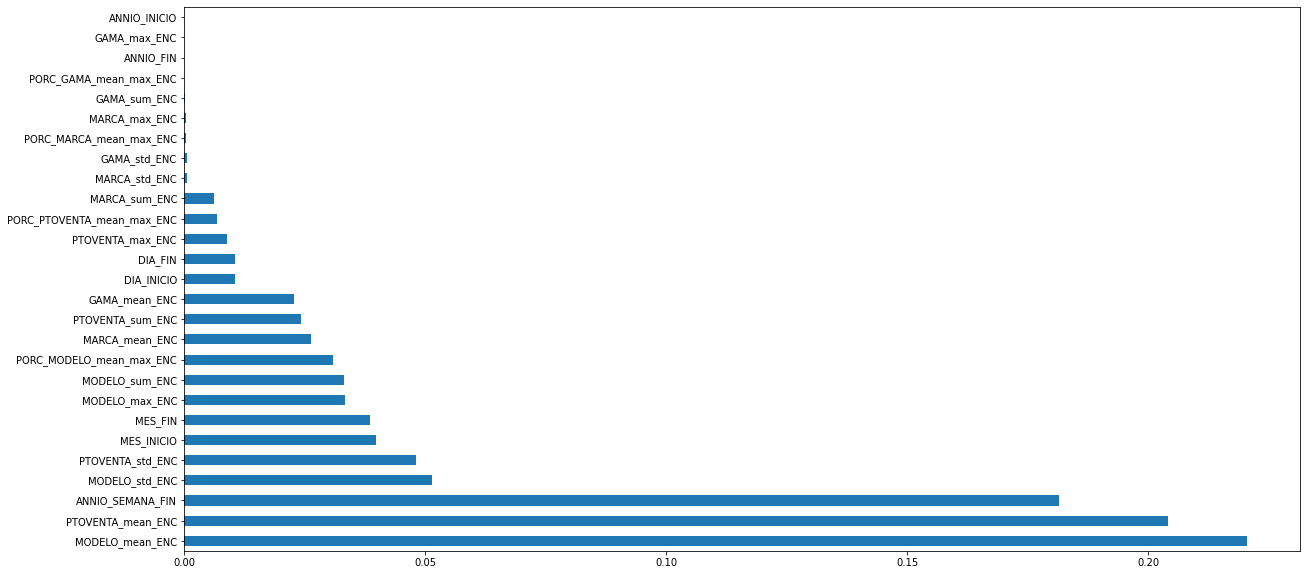

In [236]:
%matplotlib inline
features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

In [239]:
# features_importances = pd.Series(learner_xg.feature_importances_ / learner_xg.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
# _, _ = get_feature_selection(features_importances)

In [240]:
# %matplotlib inline
# features_importances.nlargest(40).plot(kind='barh', figsize=(20,10));

### SUBMISION 

In [242]:
# test.drop(['Demanda'], axis=1, inplace=True)

In [243]:
# test['Demanda'] = learner_lg.predict(test)*0.35 + learner_cb.predict(test)*0.30 +  learner_xg.predict(test)*0.35
# test['Demanda'] = learner_lg.predict(test)*0.5 + learner_xg.predict(test)*0.5
# test['Demanda'] = learner_lg.predict(test)
# test['Demanda'] = learner_cb.predict(test)
# test['Demanda'] = learner_xg.predict(test)
test['Demanda'] = np.array(pd.Series(learner_cb.predict(test)).apply(lambda x: 0 if x<0 else x)*0.5+\
                           pd.Series(learner_lg.predict(test)).apply(lambda x: 0 if x<0 else x)*0.5)
test['Demanda'] = test['Demanda'].apply(lambda x: 0 if x<0 else x)

In [244]:
test_submit = test.reset_index()[['ID','Demanda']]
test_submit

,ID,Demanda
0,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.266554
1,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.260563
2,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.269536
3,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.232382
4,1161c077d04c02902341ddd6f20f322d6fdaac2619ecf1...,0.205577
...,...,...
471725,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.000000
471726,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.000000
471727,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.000000
471728,ddf2b5328dafe4a5863dc2463578ea789284d951943120...,0.000000


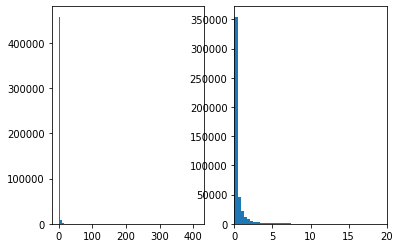

In [245]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(test['Demanda'], bins=100);
ax2.hist(test['Demanda'], bins=1000);
plt.xlim(0,20);

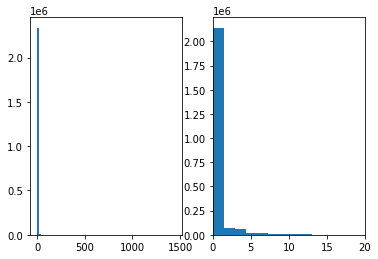

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(y_train, bins=100);
ax2.hist(y_train, bins=1000);
plt.xlim(0,20);

In [247]:
test_submit['Demanda'].describe()

count    471730.000000
mean          0.661825
std           3.293362
min           0.000000
25%           0.023184
50%           0.113964
75%           0.407601
max         411.853779
Name: Demanda, dtype: float64

In [248]:
test_submit.to_csv('../results/test_ensamble_cb_lg.csv', index=False)

In [ ]:
!kaggle competitions submit datathon-entel-2022-reto2 -f ../results/test_ensamble_cb_lg.csv -m "test"